\newpage

# 0 Set Up {-}

In [1]:
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# ignore tensorflow depreciation warnings
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## 0.1 Visualizing Dataset {-}

It's always important to visualize the dataset to gain and understanding of what the model is trying to accomplish. This can help in the debugging phase. The shape of each data set is printed out as well as a random sample of the training data is plotted.

In [4]:
# given by the assignment
def loadData():
    with np.load('notMNIST.npz') as data :
        Data, Target = data['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

\newpage

In [5]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
print(f"Training Data: {trainData.shape}\tTraining tagets: {trainTarget.shape}")
print(f"Validation Data: {validData.shape}\tValidation tagets: {validTarget.shape}")
print(f"Testing Data: {testData.shape}\tTesting tagets:{testTarget.shape}")

Training Data: (3500, 28, 28)	Training tagets: (3500, 1)
Validation Data: (100, 28, 28)	Validation tagets: (100, 1)
Testing Data: (145, 28, 28)	Testing tagets:(145, 1)


In [6]:
def plot(image, target, ax=None):
    ax = plt.gca() if ax == None else ax
    ax.imshow(image, cmap="hot")
    ax.set_title('J' if target == 0 else 'C')
    # targets are binary encoded 0 == 'J' and 1 == 'C'

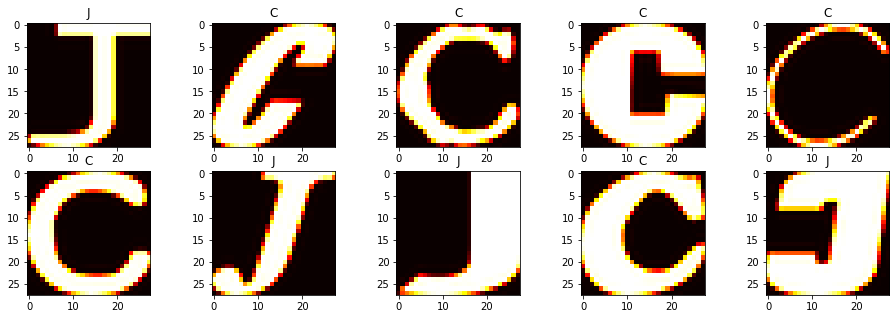

In [7]:
fig, axis = plt.subplots(2, 5, figsize=(16, 5))
for ax in axis.reshape(-1):
    r = np.random.randint(trainData.shape[0])
    plot(trainData[r], trainTarget[r], ax=ax)
plt.show()

\newpage

## 0.2 Useful Functions {-}

Some useful functions that will be used throughout the assignment such as getting random weights, getting the accuracy of a batch, making the loss and accuracy plots look nice, and global variables used throughout the code

In [8]:
def augment(X, w, b):
    # flatten X
    if len(X.shape) == 3:
        X = X.reshape(X.shape[0], -1)
    
    # insert 1's at position 0 along the columns
    X = np.insert(X, 0, 1, axis=1)
    
    # insert b at the front of W
    w = np.insert(w, 0, b, axis=0)
    
    return X, w

def get_zero_parameters():
    w = np.zeros(d)
    b = np.zeros(1)
    return w, b

def get_random_parameters():
    w = np.random.uniform(low=-1.0, high=1.0, size=(d,))
    b = np.random.uniform(low=-1.0, high=1.0, size=(1,))
    return w, b

In [9]:
def predict(w, b, X):
    X = X.reshape(X.shape[0], -1)
    return X.dot(w) + b

def accuracy(w, b, X, y):
    y = y.reshape(-1)
    y_pred = predict(w, b, X)
    y_pred = np.vectorize(lambda z: 1 if z > 0 else 0)(y_pred)
    return np.sum(y_pred == y) / y.shape[0]

def accuracy_with_predictions(y_pred, y):
    if y_pred.shape != y.shape:
        raise ValueError(f"prediction dimension {y_pred.shape} and label dimensions {y.shape} don't match")
    y_pred = np.vectorize(lambda z: 1 if z > 0 else 0)(y_pred)
    return np.sum(y_pred == y) / y.shape[0]

In [10]:
def plot_loss(x, train_loss=None, valid_loss=None, test_loss=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_loss != None:
        ax.plot(x, train_loss, label="Training Loss")
    if valid_loss != None:
        ax.plot(x, valid_loss, label="Validation Loss")
    if test_loss != None:
        ax.plot(x, test_loss, label="Testing Loss")
    
    ax.set_title("Loss" if title == None else title)
    
    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Loss")
    ax.set_ylim(bottom=0)
    ax.legend(loc="upper right")

def plot_accuracy(x, train_accuracy=None, valid_accuracy=None, test_accuracy=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_accuracy != None:
        ax.plot(x, train_accuracy, label="Training Accuracy")
    if valid_accuracy != None:
        ax.plot(x, valid_accuracy, label="Validation Accuracy")
    if test_accuracy != None:
        ax.plot(x, test_accuracy, label="Testing Accuracy")
    
    ax.set_title("Accuracy" if title == None else title)

    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Accuracy")
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.grid(linestyle='-', axis='y')
    ax.legend(loc="lower right")

def display_statistics(train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc):
    print(f"Training loss: {train_loss[-1]:.4f}{'':.20s}\t\tTraining acc: {train_acc[-1]*100:.2f}%")
    print(f"Validation loss: {valid_loss[-1]:.4f}\t\tValidation acc: {valid_acc[-1]*100:.2f}%")
    print(f"Testing loss: {test_loss[-1]:.4f}\t\tTesting acc: {test_acc[-1]*100:.2f}%")
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
    plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
    plt.show()
    plt.close()

In [11]:
VTDatasets = {"validData" : validData, "validTarget" : validTarget,
              "testData" : testData, "testTarget" : testTarget}

N = trainData.shape[0]
d = trainData.shape[1] * trainData.shape[2]

\newpage

# 1 Linear Regression {-}
### 1. Loss Function and Gradient {-}

$$
\hat{y}^{(n)} = W^T \textbf{x}^{(n)} + b
$$

$$
\mathcal{L}_{MSE} = \frac{1}{N}\sum_{n=1}^N(\hat{y}^{(n)} - y^{(n)})^2 + \lambda \Vert W \Vert_2^2
$$

$$
\frac{\partial \mathcal{L}_{MSE}}{\partial b} = \frac{2}{N} \sum_{n=1}^N (\hat{y}^{(n)} - y^{(n)})
$$

$$
\frac{\partial \mathcal{L}_{MSE}}{\partial W} = \frac{2}{N} \ X^T \left ( \hat{
\textbf{y}} - \textbf{y} \right ) + \lambda W
$$


In [12]:
def MSE(w, b, X, y, reg):
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(-1)
    return np.square(X.dot(w) + b - y).mean() + reg * np.square(w).sum()

def gradMSE(w, b, X, y, reg):
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(-1)
    N = y.shape[0]
    
    w_grad = 2.0/N * X.T.dot(X.dot(w) + b - y) + reg * w
    b_grad = 2.0/N * np.sum(X.dot(w) + b - y)
    return w_grad, b_grad

\newpage

### 2. Gradient Descent Implementation {-}

In [13]:
def grad_descent_MSE(w, b, X, y, alpha, epochs, reg, error_tol=1e-7, 
                     validData=None, validTarget=None, testData=None, testTarget=None):
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    test_loss, test_acc = [], []
    for i in range(epochs):
        grad_w, grad_b = gradMSE(w, b, X, y, reg)
        w -= alpha * grad_w
        b -= alpha * grad_b
        
        # Calculating Statistics
        train_loss.append( MSE(w, b, X, y, reg) )
        train_acc.append( accuracy(w, b, X, y) )

        if not validData is None and not validTarget is None:
            valid_loss.append( MSE(w, b, validData, validTarget, reg) )
            valid_acc.append( accuracy(w, b, validData, validTarget) )
        if not testData is None and not testTarget is None:
            test_loss.append( MSE(w, b, testData, testTarget, reg) )
            test_acc.append( accuracy(w, b, testData, testTarget) )

        # Check stopping condition
        if i > 1 and np.abs(train_loss[-2] - train_loss[-1]) <= error_tol:
            break

    statistics = (train_loss, train_acc)
    if not validData is None and not validTarget is None:
        statistics += (valid_loss, valid_acc, )
    if not testData is None and not testTarget is None:
        statistics += (test_loss, test_acc,)
    # Python 3.8 made this easier, but 3.7 you have to do this
    out = (w, b, *statistics)
    
    return out

\newpage

### 3. Tuning the Learning Rate {-}

alpha = 0.005
Training loss: 0.4199		Training acc: 70.11%
Validation loss: 0.5428		Validation acc: 71.00%
Testing loss: 0.7137		Testing acc: 66.21%


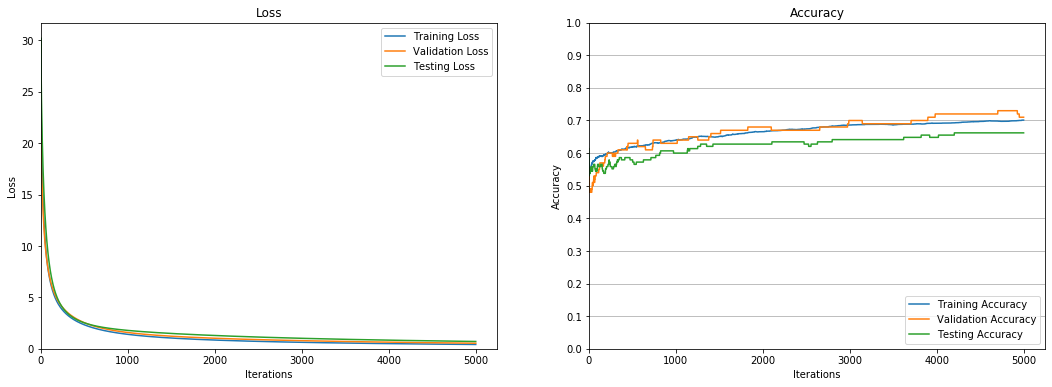

alpha = 0.001
Training loss: 1.4922		Training acc: 62.17%
Validation loss: 2.1204		Validation acc: 62.00%
Testing loss: 1.6711		Testing acc: 63.45%


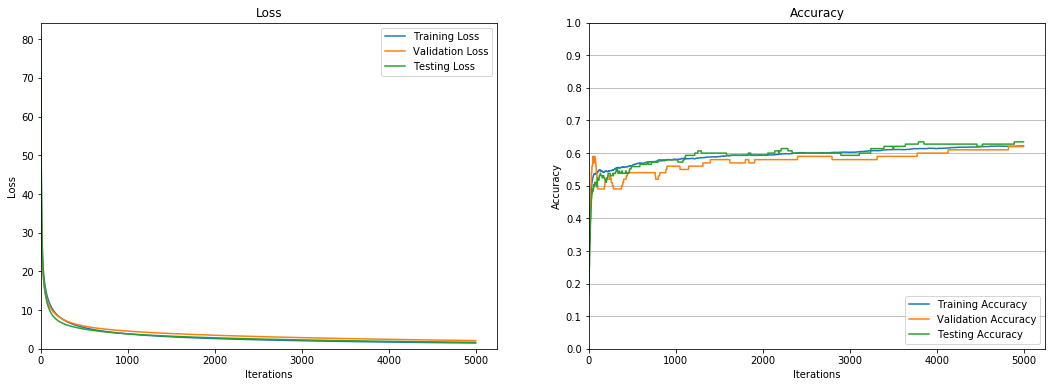

alpha = 0.0001
Training loss: 5.5281		Training acc: 57.34%
Validation loss: 6.0496		Validation acc: 55.00%
Testing loss: 7.3279		Testing acc: 55.17%


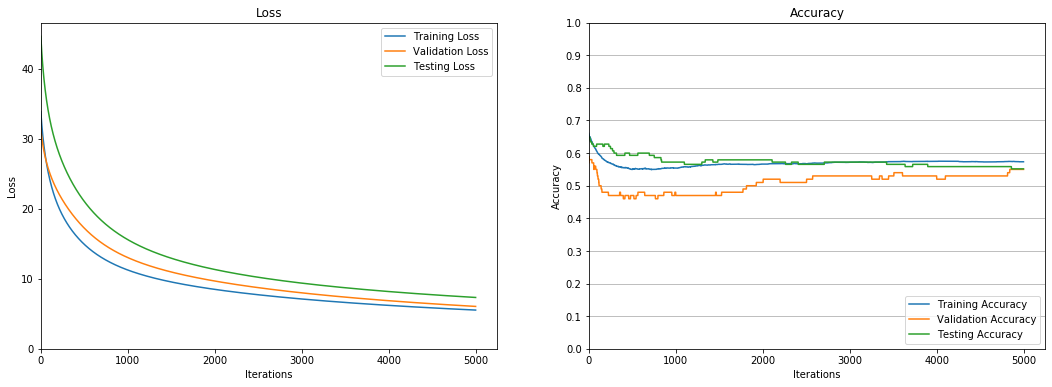

In [14]:
for alpha in [0.005, 0.001, 0.0001]:
    
    print("alpha =", alpha)
    
    w, b = get_random_parameters()
    w, b, *statistics = grad_descent_MSE(w, b, trainData, trainTarget, 
                                         alpha=alpha, 
                                         epochs=5000, 
                                         reg=0, 
                                         **VTDatasets)
    display_statistics(*statistics)

\newpage

### 4. Generalization {-}

regularization = 0.001
Training loss: 0.5822		Training acc: 69.54%
Validation loss: 0.8218		Validation acc: 61.00%
Testing loss: 0.8229		Testing acc: 69.66%


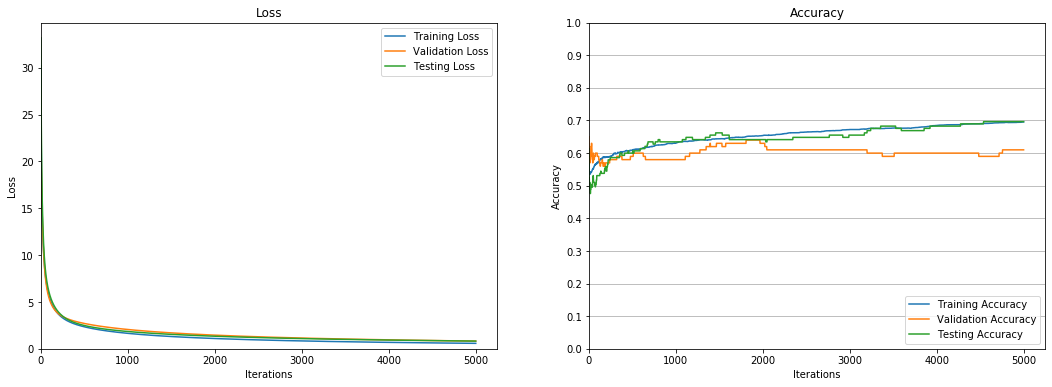

regularization = 0.1
Training loss: 0.1332		Training acc: 68.60%
Validation loss: 0.1355		Validation acc: 65.00%
Testing loss: 0.1393		Testing acc: 64.14%


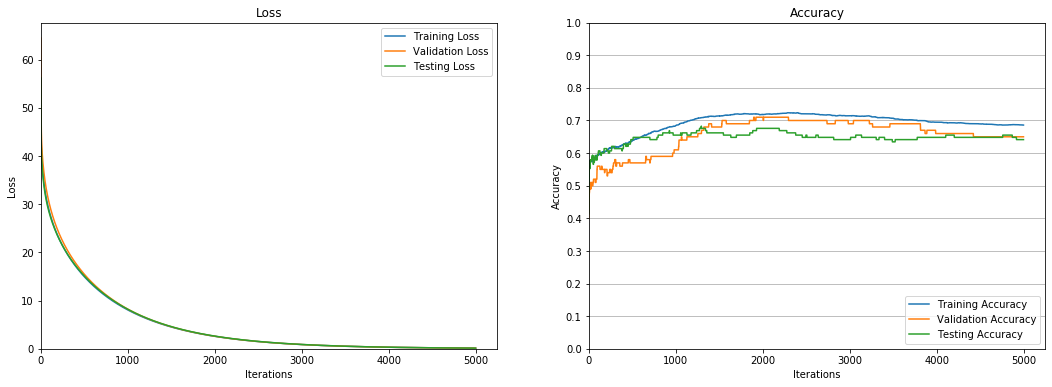

regularization = 0.5
Training loss: 0.0416		Training acc: 65.94%
Validation loss: 0.0451		Validation acc: 66.00%
Testing loss: 0.0442		Testing acc: 61.38%


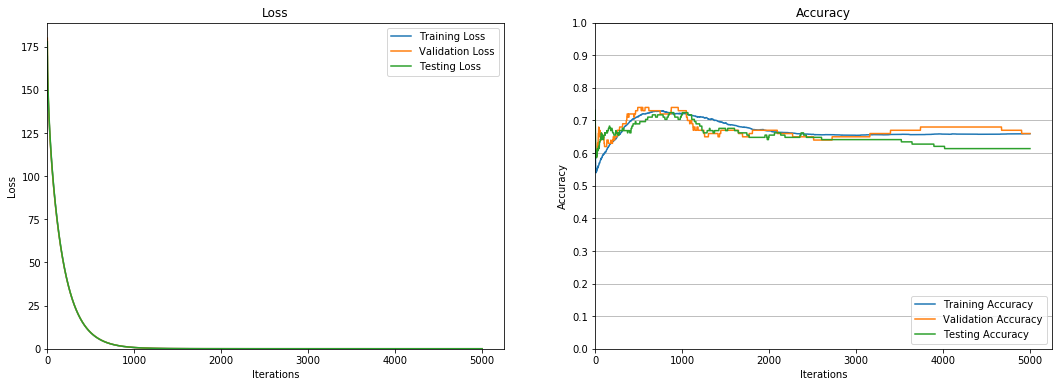

In [15]:
for reg in [0.001, 0.1, 0.5]:
    
    print("regularization =", reg)
    
    w, b = get_random_parameters()
    w, b, *statistics = grad_descent_MSE(w, b, trainData, trainTarget, 
                                         alpha=0.005, 
                                         epochs=5000, 
                                         reg=reg, 
                                         **VTDatasets)
    display_statistics(*statistics)

\newpage

### 5. Comparing Batch GD with normal equation {-}

In [16]:
def least_squares(X, y):
    N = X.shape[0]
    d = X.shape[1] * X.shape[2]
    X = X.reshape(X.shape[0], -1)
    X = np.insert(X, 0, 1, axis=1)
    y = y.reshape(-1)
    
    # overparameterized (deep learning)
    if N < d:
        w_aug = X.T @ np.linalg.inv( X @ X.T ) @ y
    
    # underparameterized (typical case)
    else:
        w_aug = np.linalg.inv( X.T @ X ) @ X.T @ y
    
    return w_aug[1:], w_aug[0]

In [17]:
w_LS, b_LS = least_squares(trainData, trainTarget)

loss = MSE(w_LS, b_LS, trainData, trainTarget, 0)
acc = accuracy(w_LS, b_LS, trainData, trainTarget)
print(f"Least Squares Training loss: {loss:.4f}\tLeast Squares Training acc: {100*acc:.2f}%")
loss = MSE(w_LS, b_LS, validData, validTarget, 0)
acc = accuracy(w_LS, b_LS, validData, validTarget)
print(f"Least Squares Validation loss: {loss:.4f}\tLeast Squares Validation acc: {100*acc:.2f}%")
loss = MSE(w_LS, b_LS, testData, testTarget, 0)
acc = accuracy(w_LS, b_LS, testData, testTarget)
print(f"Least Squares Testing loss: {loss:.4f}\tLeast Squares Testing acc: {100*acc:.2f}%")

Least Squares Training loss: 0.0187	Least Squares Training acc: 71.29%
Least Squares Validation loss: 0.0476	Least Squares Validation acc: 69.00%
Least Squares Testing loss: 0.0570	Least Squares Testing acc: 66.90%


The least squares solution achived a the training loss of 0.0187 and training accuracy of 71.29%. The training loss and accuracy for Batch Gradient Descent were 0.4199 and 70.11%, respectively. From the values, we see that the analytical solution performed marginally better. However, computing it grows increasingly difficult with the size of the problem. By constrast, batch gradient descent allows for faster convergence with less computation and comparable accuracies.

\newpage

# 2 Logistic Regression {-}
## 2.1 Binary cross-entropy loss {-}
### 1. Loss Function and Gradient {-}

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

$$
\hat{y}^{(n)} = \sigma(W^T\textbf{x}^{(n)} + b)
$$

$$
\mathcal{L}_{CE} = \frac{1}{N}\sum_{n=1}^{N} \left [ -y^{(n)} \log(\hat{y}^{(n)}) -(1- y^{(n)}) \log (1 - \hat{y}^{(n)} ) \right ] + \frac{\lambda}{2} \Vert W \Vert^2_2
$$

$$
\frac{\partial \mathcal{L}_{CE}}{\partial b} = \frac{1}{N} \sum_{n=1}^{N} \left [ \hat{y}^{(n)} - y^{(n)} \right ]
$$

$$
\frac{\partial \mathcal{L}_{CE}}{\partial W} = \frac{1}{N} \sum_{n=1}^{N} \left [ (\hat{y}^{(n)} - y^{(n)}) \ \textbf{x}^{(n)} \right ] + \lambda W
$$

In [18]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))
    
def crossEntropyLoss(w, b, X, y, reg):    
    X, w = augment(X, w, b)
    y = y.reshape(-1)
    N = y.shape[0]
    
    y_hat = sigmoid(X.dot(w))
    
    return 1.0/N * (-y.dot(np.log(y_hat+1e-20)) - (1 - y).dot(np.log(1 - y_hat+1e-20))) + reg/2.0 * np.square(w[1:]).sum()
    
def gradCE(w, b, X, y, reg):
    X, w = augment(X, w, b)
    y = y.reshape(-1)
    N = y.shape[0]
    
    y_hat = sigmoid(X.dot(w))
    
    grad = 1.0 /N * X.T.dot(y_hat - y) + reg * w
    
    return grad[1:], grad[0] - reg * w[0]

### 2. Learning {-}

In [19]:
def grad_descent(w, b, X, y, alpha, epochs, reg, error_tol=1e-7, lossType="MSE", 
                 validData=None, validTarget=None, testData=None, testTarget=None):
    loss_func, grad_func = None, None
    if lossType == "MSE":
        loss_func, grad_func = MSE, gradMSE
    elif lossType == "CE":
        loss_func, grad_func = crossEntropyLoss, gradCE
    else:
        raise ValueError("Variable 'lossType' must be either 'MSE' or 'CE'.")
    
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    test_loss, test_acc = [], []
    printing = False
    for i in range(epochs):
        grad_w, grad_b = grad_func(w, b, X, y, reg)
        w -= alpha * grad_w
        b -= alpha * grad_b

        # Calculating Statistics
        train_loss.append(loss_func(w, b, X, y, reg))
        train_acc.append(accuracy(w, b, X, y))

        if not validData is None and not validTarget is None:
            valid_loss.append(loss_func(w, b, validData, validTarget, reg))
            valid_acc.append(accuracy(w, b, validData, validTarget))
        if not testData is None and not testTarget is None:
            test_loss.append(loss_func(w, b, testData, testTarget, reg))
            test_acc.append(accuracy(w, b, testData, testTarget))

        # Check stopping condition
        if i > 1 and np.abs(train_loss[-2] - train_loss[-1]) <= error_tol:
            break

    statistics = (train_loss, train_acc)
    if not validData is None and not validTarget is None:
        statistics += (valid_loss, valid_acc,)
    if not testData is None and not testTarget is None:
        statistics += (test_loss, test_acc,)
    out = (w, b, *statistics)

    return out

Training loss: 0.1992		Training acc: 98.06%
Validation loss: 0.2082		Validation acc: 98.00%
Testing loss: 0.2055		Testing acc: 97.93%


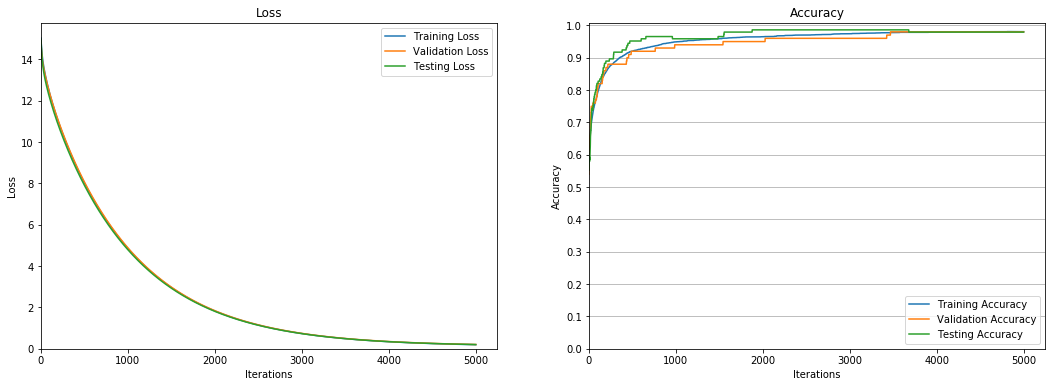

In [20]:
w, b = get_random_parameters()
w, b, *statistics = grad_descent(w, b, trainData, trainTarget, 
                                 alpha=0.005, 
                                 epochs=5000, 
                                 reg=0.1,
                                 lossType='CE',
                                 **VTDatasets)
display_statistics(*statistics)

\newpage

### 3. Comparision to Linear Regression {-}

Linear Regression
Training loss: 0.4194		Training acc: 70.69%
Validation loss: 0.5375		Validation acc: 74.00%
Testing loss: 0.4956		Testing acc: 68.97%


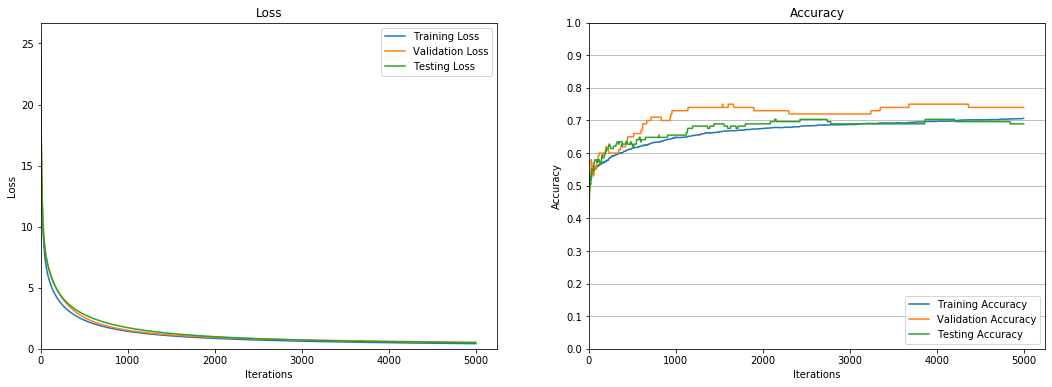

Logistic Regression
Training loss: 0.0553		Training acc: 98.14%
Validation loss: 0.0647		Validation acc: 97.00%
Testing loss: 0.0847		Testing acc: 97.93%


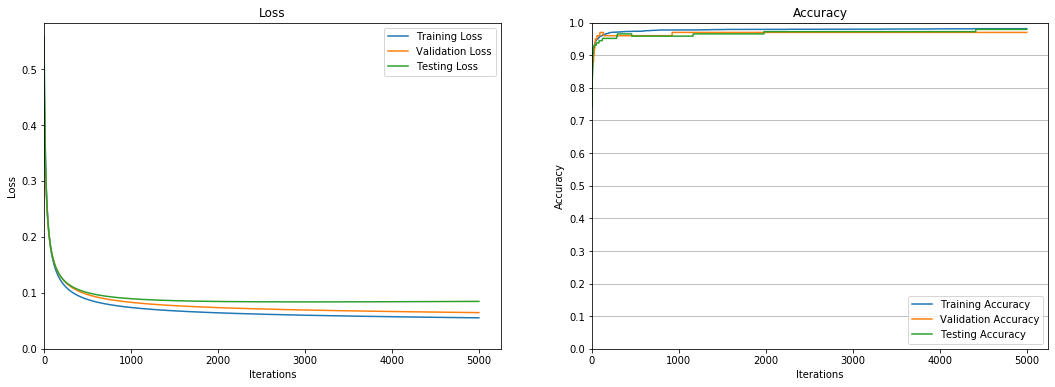

In [21]:
# same initialization for each to a more fair comparison
w, b = get_random_parameters()

# Linear Regresesion
print("Linear Regression")
w_lin, b_lin, *statistics = grad_descent(w, b, trainData, trainTarget, 
                                         alpha=0.005, 
                                         epochs=5000, 
                                         reg=0,
                                         lossType='MSE',
                                         **VTDatasets)
display_statistics(*statistics)


# Logistic Regression
print("Logistic Regression")
w_log, b_log, *statistics = grad_descent(w, b, trainData, trainTarget, 
                                         alpha=0.005, 
                                         epochs=5000, 
                                         reg=0,
                                         lossType='CE',
                                         **VTDatasets)
display_statistics(*statistics)

The cross-entropy loss function allows for much faster convergence to a more optimal minimum compared to the MSE loss function. This is due to the fact that cross-entropy punishes wrong predictions much more than MSE.

\newpage

# 3 Batch Gradient Descent vs. SGD and Adam {-}
## 3.1 SGD {-}
### 1. Building the Computational Graph {-}

In [22]:
def buildGraph(alpha, reg=0, beta1=None, beta2=None, epsilon=None, loss="MSE", seed=None):
    kwargs = {}
    if beta1 != None:
        kwargs["beta1"] = beta1
    if beta2 != None:
        kwargs["beta2"] = beta2
    if epsilon != None:
        kwargs["epsilon"] = epsilon
    
    # Initialize weight and bias tensors
    tf.set_random_seed(seed)
    tf.compat.v1.set_random_seed(seed)
    tf.compat.v1.disable_eager_execution()

    # Getting small random initial values for weights and bias
    w = tf.truncated_normal([d, 1], stddev=0.5)
    b = tf.truncated_normal([1, 1], stddev=0.5)
    # Converting into tensorflow Variable objects
    w = tf.Variable(w, name="weights")
    b = tf.Variable(b, name="bias")

    # tensorflow objects for data
    X = tf.placeholder(tf.float32, (None, d))
    y = tf.placeholder(tf.float32, (None, 1))

    y_pred = None
    cost = None
    if loss == "MSE":
        y_pred = tf.matmul(X, w) + b
        cost = tf.losses.mean_squared_error(y, y_pred) + reg * tf.norm(w)**2
    elif loss == "CE":
        y_pred = tf.sigmoid(tf.matmul(X, w) + b)
        cost = tf.losses.sigmoid_cross_entropy(y, y_pred)
    else:
        raise ValueError("Variable 'lossType' must be either 'MSE' or 'CE'.")

    opt = tf.train.AdamOptimizer(learning_rate=alpha, **kwargs).minimize(cost)

    return w, b, X, y, y_pred, cost, opt

### 2. Implementing Stochastic Gradient Descent {-}

In [23]:
class BatchLoader(object):

    """
    Custom robust batch loader class
    """
    
    def __init__(self, data, batch_size=None, randomize=True, drop_last=False, seed=None):
    
        # error checking
        if len(data) > 1:
            for i in range(len(data)-1):
                if data[i].shape[0] != data[i+1].shape[0]:
                    raise ValueError("All inputs must have the same number of elements")
    
        self.data = data if type(data) == tuple else (data, )
        self.N = data[0].shape[0]
        self.batch_size = batch_size if batch_size != None else self.N
        self.drop_last = drop_last

        # shuffling data
        if randomize:
            indices = np.arange(self.N)
            np.random.seed(seed)
            np.random.shuffle(indices)
            self.data = tuple([d[indices] for d in self.data])
    
        self.index = 0 

    def __iter__(self):
        return self
    
    def __next__(self):
    
        # stop condition
        if self.index >= self.N:
            self.index = 0          # resetting index for next iteration
            raise StopIteration

        # iterating
        self.index += self.batch_size
    
        if self.index > self.N:
            if self.drop_last:
                self.index = 0      # resetting index for next iteration
                raise StopIteration
            else:
                return tuple([ d[self.index - self.batch_size: ] for d in self.data ])
        else:
            return tuple([ d[self.index - self.batch_size: self.index] for d in self.data ])

In [24]:
def SGD(X, y, alpha, epochs, reg, error_tol=1e-7, lossType="MSE",
              batch_size=500, randomize=True, beta1=None, beta2=None, epsilon=None,
              validData=None, validTarget=None, testData=None, testTarget=None):
    
    X = X.reshape(X.shape[0], -1)
    if not validData is None:
        validData = validData.reshape(validData.shape[0], -1)
    if not testData is None:
        testData = testData.reshape(testData.shape[0], -1)
    
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    test_loss, test_acc = [], []
    printing = False
    
    running_loss = 0.0
    running_acc = 0.0
    
    w, b, X_tf, y_tf, y_pred_tf, cost, \
    optimizer = buildGraph(alpha=alpha, reg=reg, loss=lossType,
                           beta1=beta1, beta2=beta2, epsilon=epsilon)
    
    batch_iter = BatchLoader((X, y), batch_size=500, randomize=False)

    init = tf.initialize_all_variables()
    with tf.Session() as sess:
        sess.run(init)
        for e in range(epochs):
            for X_batch, y_batch in batch_iter:
                # updating the weights
                sess.run(optimizer, feed_dict={X_tf: X_batch, y_tf: y_batch})
                
                # getting the cost
                running_loss += sess.run(cost, feed_dict={X_tf: X_batch, y_tf: y_batch}) * X_batch.shape[0]
                y_pred = sess.run(y_pred_tf, feed_dict={X_tf: X_batch, y_tf: y_batch})
                running_acc += accuracy_with_predictions(y_pred.flatten(), y_batch.flatten()) * y_batch.shape[0]
                
            else:
                # Calculating Statistics
                train_loss.append(running_loss / X.shape[0])
                train_acc.append(running_acc / X.shape[0])
                running_loss = 0.0
                running_acc = 0.0

                if not validData is None and not validTarget is None:
                    valid_loss.append(sess.run(cost, feed_dict={X_tf: validData, y_tf: validTarget}))
                    y_pred = sess.run(y_pred_tf, feed_dict={X_tf: validData, y_tf: validTarget})
                    valid_acc.append(accuracy_with_predictions(y_pred.flatten(), validTarget.flatten()))
                if not testData is None and not testTarget is None:
                    test_loss.append(sess.run(cost, feed_dict={X_tf: testData, y_tf: testTarget}))
                    y_pred = sess.run(y_pred_tf, feed_dict={X_tf: testData, y_tf: testTarget})
                    test_acc.append(accuracy_with_predictions(y_pred.flatten(), testTarget.flatten()))

                continue
            break

    statistics = (train_loss, train_acc)
    if not validData is None and not validTarget is None:
        statistics += (valid_loss, valid_acc,)
    if not testData is None and not testTarget is None:
        statistics += (test_loss, test_acc,)
    out = (w, b, *statistics)
    
    return out

Training loss: 0.1192		Training acc: 73.17%
Validation loss: 0.2329		Validation acc: 73.00%
Testing loss: 0.2164		Testing acc: 68.28%


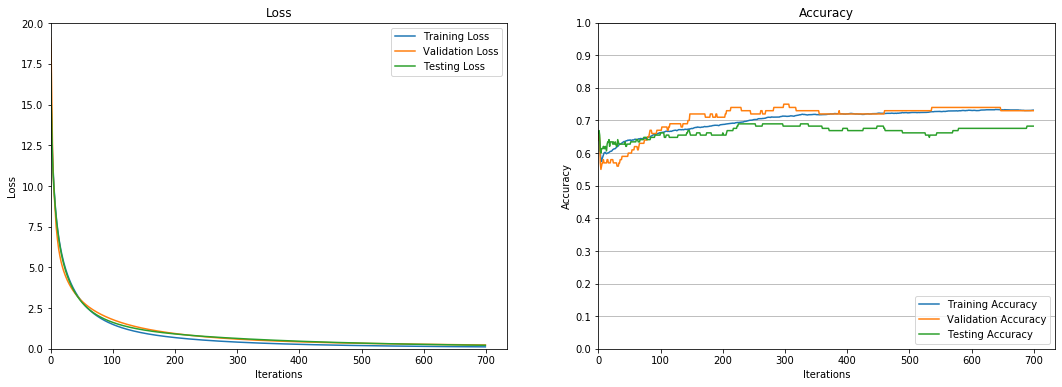

In [25]:
w, b, *statistics = SGD(trainData, trainTarget, 
                        alpha=0.001, 
                        epochs=700, 
                        reg=0,
                        lossType='MSE',
                        batch_size=500,
                        **VTDatasets)
display_statistics(*statistics)

\newpage

### 3. Batch Size Investigation {-}

batch size = 100
Training loss: 0.3860		Training acc: 69.80%
Validation loss: 0.4299		Validation acc: 69.00%
Testing loss: 0.4305		Testing acc: 68.97%


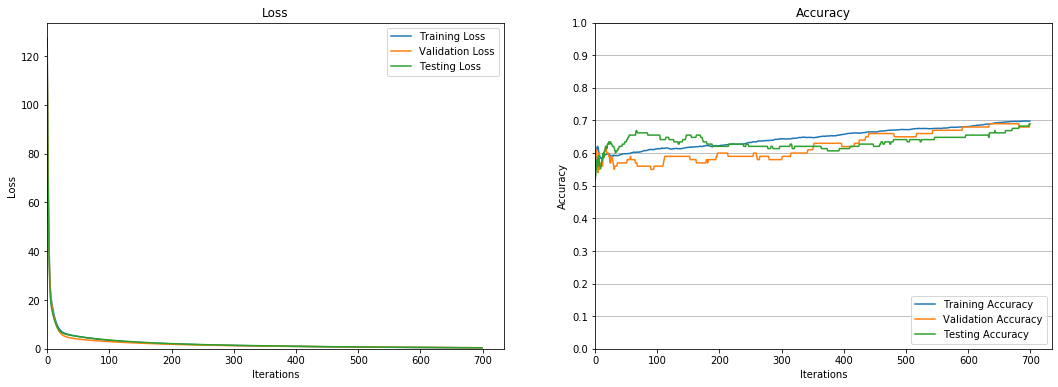

batch size = 700
Training loss: 0.3032		Training acc: 71.11%
Validation loss: 0.4878		Validation acc: 67.00%
Testing loss: 0.3485		Testing acc: 68.28%


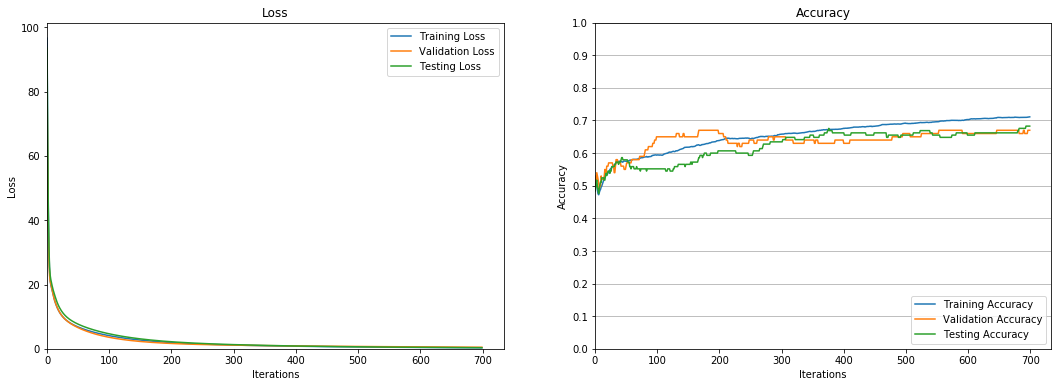

batch size = 1750
Training loss: 0.1794		Training acc: 72.20%
Validation loss: 0.3305		Validation acc: 72.00%
Testing loss: 0.2431		Testing acc: 71.72%


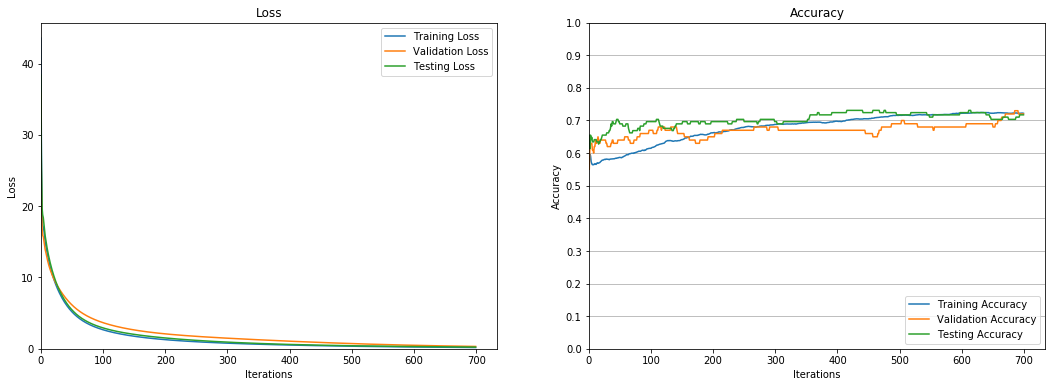

In [29]:
for batch_size in [100, 700, 1750]:
    
    print("batch size =", batch_size)
    
    w, b, *statistics = SGD(trainData, trainTarget, 
                            alpha=0.001, 
                            epochs=700, 
                            reg=0,
                            lossType='MSE',
                            batch_size=batch_size,
                            **VTDatasets)
    display_statistics(*statistics)

A smaller batch size converges better initially as seen in the graphs. A batch size of 100 jumps immediately to 60% accuracy where as a batch size of 1750 actually goes down initially. However, the batch size that was too small could not reach as optimal performance as the larger batch size. This is likely due to additional noise from the small sample size.

\newpage

### 4. Hyperparameter Investigation {-}

beta1: 0.95	beta2: 0.99	epsilon: 1e-09
Training loss: 0.0457		Training acc: 72.00%
Validation loss: 0.0839		Validation acc: 74.00%
Testing loss: 0.0960		Testing acc: 72.41%


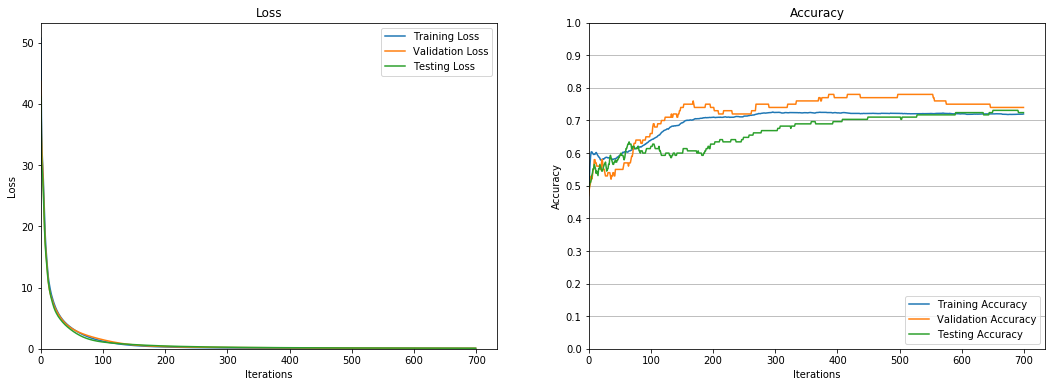

beta1: 0.95	beta2: 0.99	epsilon: 0.0001
Training loss: 0.0538		Training acc: 71.03%
Validation loss: 0.0890		Validation acc: 78.00%
Testing loss: 0.1007		Testing acc: 62.76%


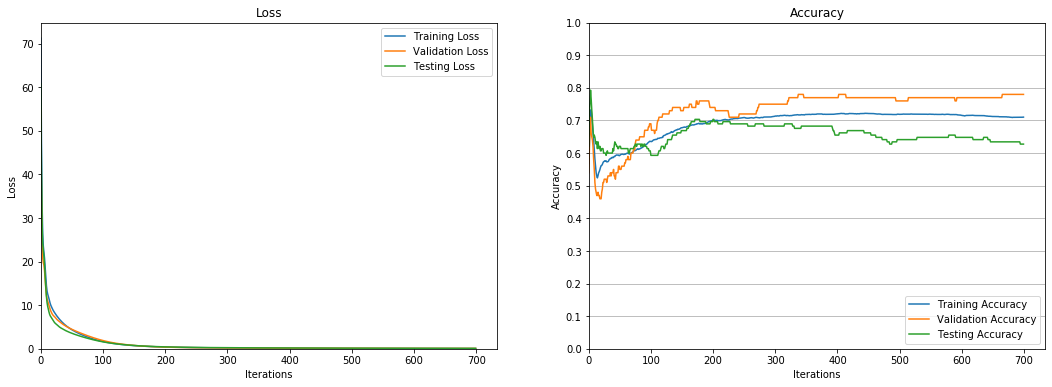

beta1: 0.95	beta2: 0.9999	epsilon: 1e-09
Training loss: 0.1798		Training acc: 72.09%
Validation loss: 0.1843		Validation acc: 69.00%
Testing loss: 0.2388		Testing acc: 67.59%


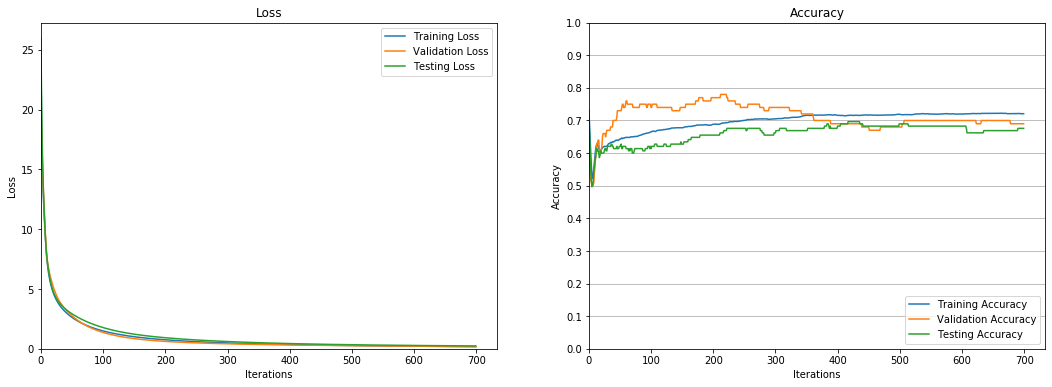

beta1: 0.95	beta2: 0.9999	epsilon: 0.0001
Training loss: 0.6275		Training acc: 69.06%
Validation loss: 0.7622		Validation acc: 68.00%
Testing loss: 0.8242		Testing acc: 73.10%


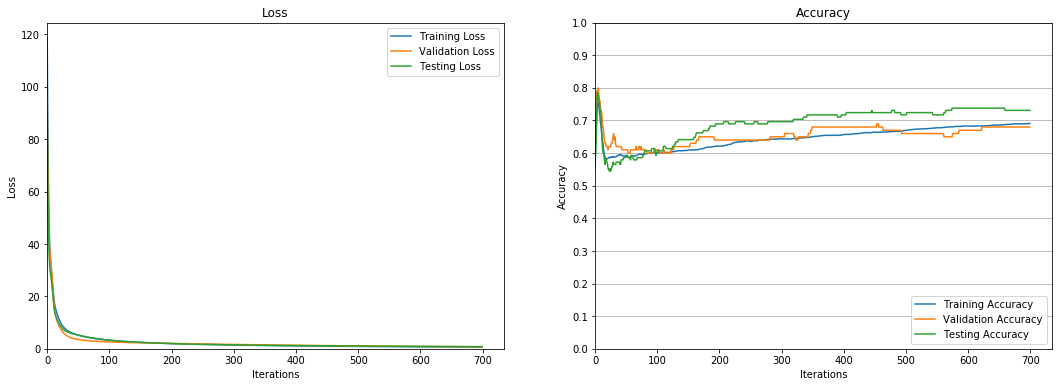

beta1: 0.99	beta2: 0.99	epsilon: 1e-09
Training loss: 0.0331		Training acc: 71.34%
Validation loss: 0.0707		Validation acc: 71.00%
Testing loss: 0.0816		Testing acc: 69.66%


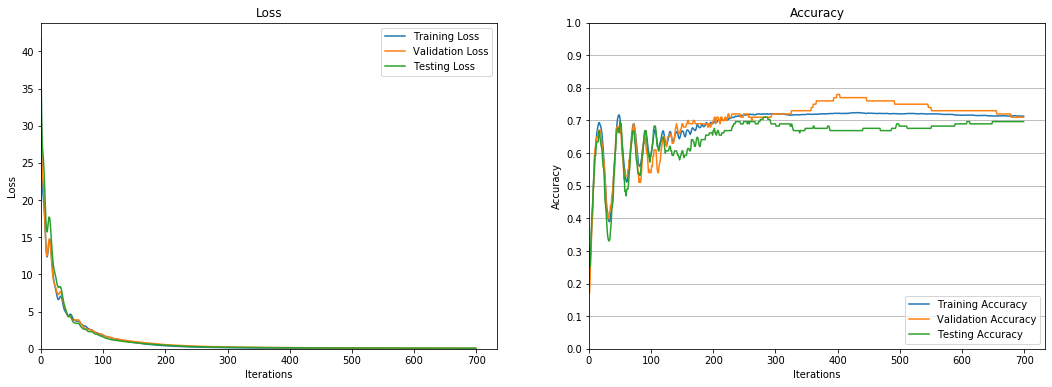

beta1: 0.99	beta2: 0.99	epsilon: 0.0001
Training loss: 0.0401		Training acc: 71.63%
Validation loss: 0.1119		Validation acc: 71.00%
Testing loss: 0.0986		Testing acc: 63.45%


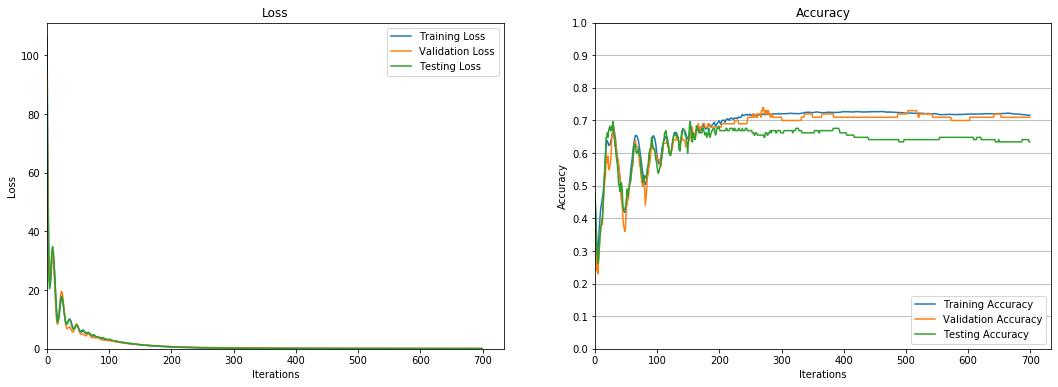

beta1: 0.99	beta2: 0.9999	epsilon: 1e-09
Training loss: 0.1370		Training acc: 72.03%
Validation loss: 0.1667		Validation acc: 72.00%
Testing loss: 0.1961		Testing acc: 66.90%


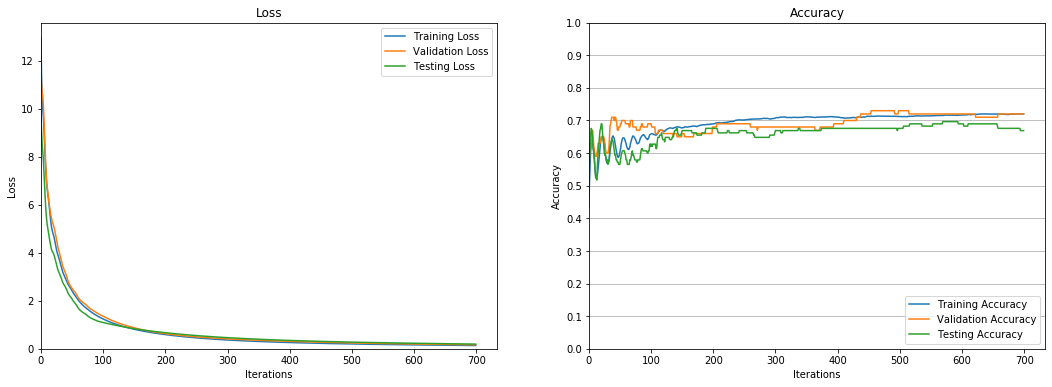

beta1: 0.99	beta2: 0.9999	epsilon: 0.0001
Training loss: 0.5262		Training acc: 68.83%
Validation loss: 0.6822		Validation acc: 65.00%
Testing loss: 0.4243		Testing acc: 71.03%


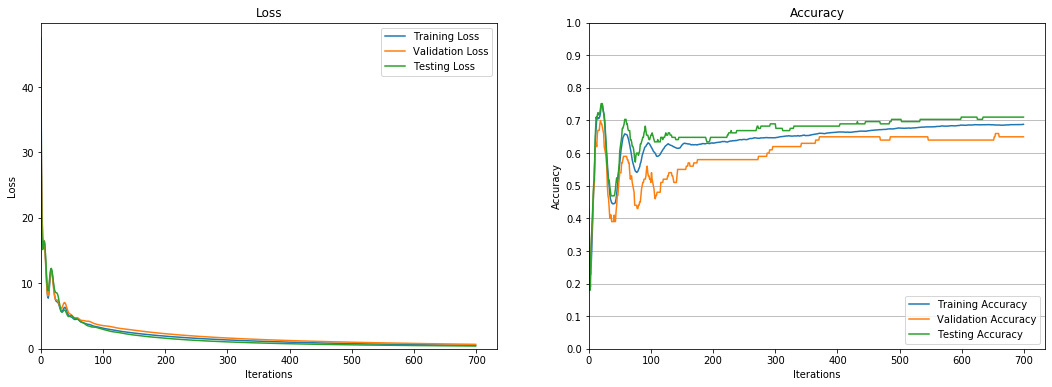

In [30]:
for beta1 in [0.95, 0.99]:
    for beta2 in [0.99, 0.9999]:
        for epsilon in [1e-9, 1e-4]:
            
            print(f"beta1: {beta1}\tbeta2: {beta2}\tepsilon: {epsilon}")
            
            w, b, *statistics = SGD(trainData, trainTarget, 
                                    alpha=0.001, 
                                    epochs=700, 
                                    reg=0,
                                    lossType='MSE',
                                    batch_size=500,
                                    beta1=beta1, beta2=beta2, epsilon=epsilon,
                                    **VTDatasets)
            display_statistics(*statistics)

The equations for the Adam optimizer given by TensorFlow are the following:
$$
lr_t = \alpha \cdot \frac{\sqrt{1 - \beta_2^t}}{1 - \beta_1^t}
$$

$$
m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g
$$

$$
v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g^2
$$

$$
var = var - lr_t \cdot \frac{m_t}{\sqrt{v_t} + \epsilon}
$$

Epsilon is a small constant which helps with numerical stability. It ensures we don't divide by zero in the optimization step (in the case where $v_t = 0$). Epsilon of $10^{-4}$ is far too large and causes the optimization to make wrong corrections. This can be seen in the every second graph where initially all accuracies dip and the final accuracies of the datasets do not necessarily converge like they do when epsilon is $10^{-9}$.

beta1 is the exponential decay rate for the first momentum estimate. Graphs with beta1 of 0.99 oscillate a lot in early iterations compared to a value of 0.95. Looking at the equations, this is most likely due to the adaptive step size: $lr_t$. The term $1 - \beta_1^t$ for beta1's close to 1 in early iterations will be very small, causing the step size to be very large and the parameters to oscillate. In later iterations, since beta1 is take to the power of $t$, this effect smooths out.

beta2 is the exponential decay rate for the second momentum estimate. Graphs with beta2 of 0.99 seem to oscillate less at the beginning, but converge faster at the end compared to graphs with beta2 of 0.9999. The oscillation is due to the opposite reason as beta1, since the term $1 - \beta_2$ is in the numerate of $lr_t$. The convergence at the end is most likely due to the $(1 - \beta_2) \cdot g^2$ term. If beta2 is too small, then $(1 - \beta_2)$ will be too large and the squared gradient will begin to dominate, causing the momentum to become too large.

\newpage

### 5. Cross Entropy Loss Investigation {-}

Training loss: 0.5077		Training acc: 86.03%
Validation loss: 0.5110		Validation acc: 75.00%
Testing loss: 0.5372		Testing acc: 82.76%


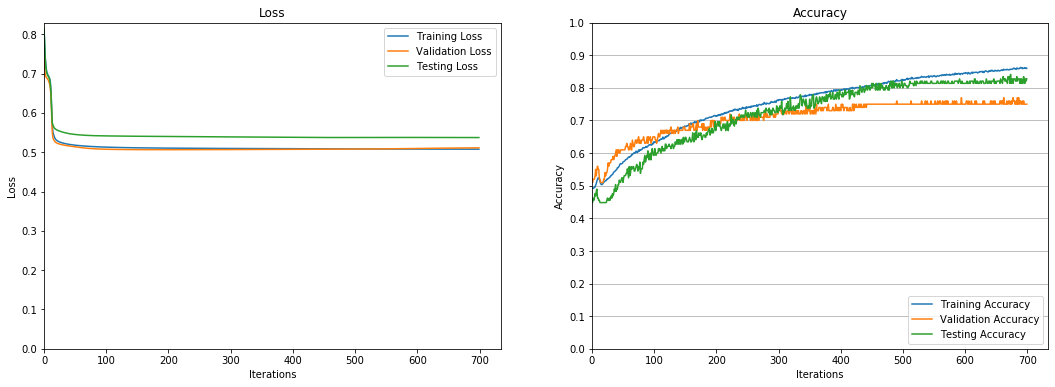

In [31]:
# 3.1.2 with Cross Entropy Loss
w, b, *statistics = SGD(trainData, trainTarget, 
                        alpha=0.001, 
                        epochs=700, 
                        reg=0,
                        lossType='CE',
                        batch_size=500,
                        **VTDatasets)
display_statistics(*statistics)

beta1: 0.95	beta2: 0.99	epsilon: 1e-09
Training loss: 0.5071		Training acc: 93.54%
Validation loss: 0.5122		Validation acc: 89.00%
Testing loss: 0.5338		Testing acc: 93.79%


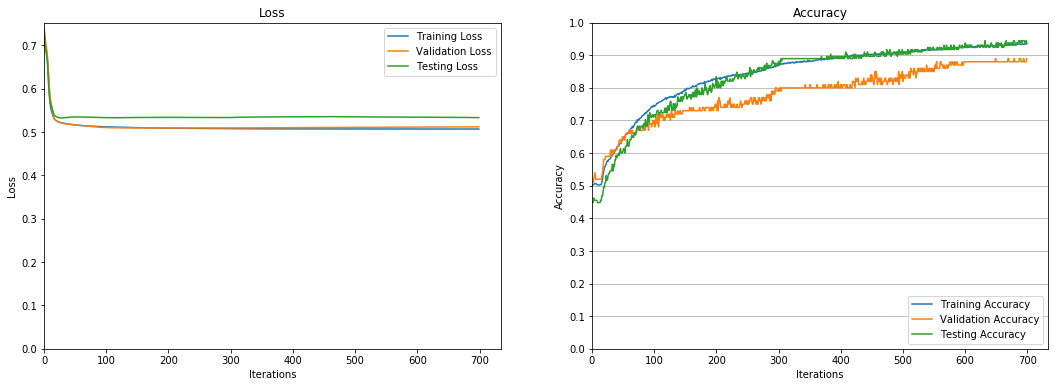

beta1: 0.95	beta2: 0.99	epsilon: 0.0001
Training loss: 0.5077		Training acc: 90.34%
Validation loss: 0.5063		Validation acc: 80.00%
Testing loss: 0.5344		Testing acc: 89.66%


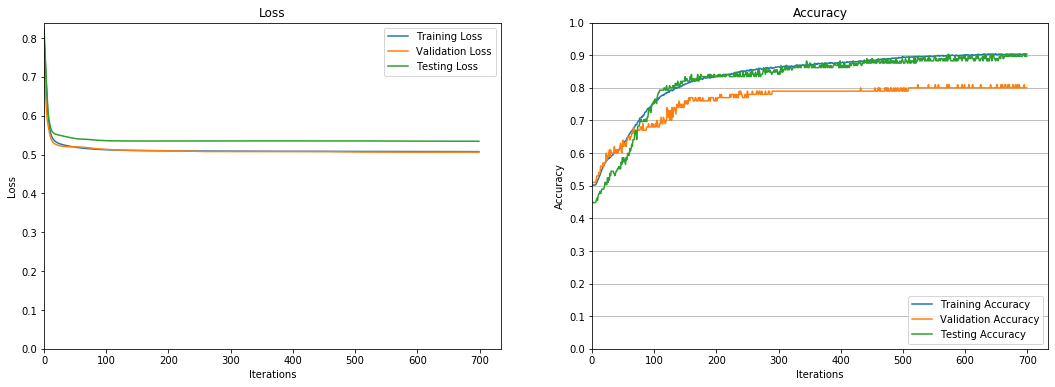

beta1: 0.95	beta2: 0.9999	epsilon: 1e-09
Training loss: 0.5084		Training acc: 83.34%
Validation loss: 0.5160		Validation acc: 77.00%
Testing loss: 0.5356		Testing acc: 80.00%


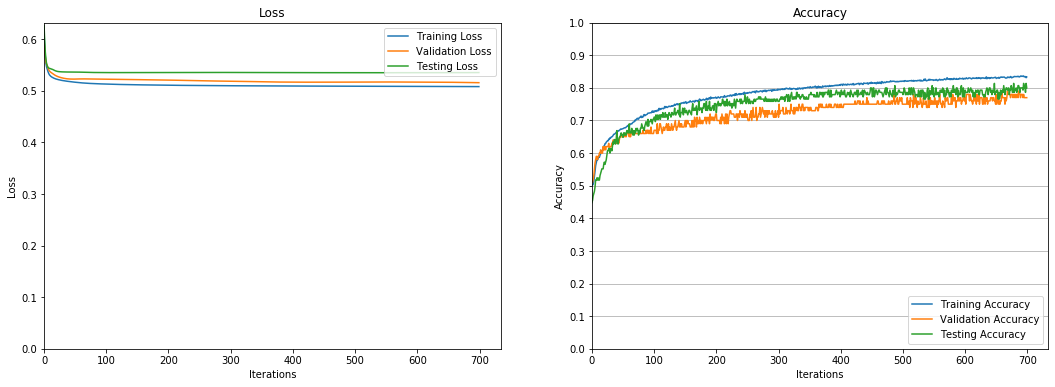

beta1: 0.95	beta2: 0.9999	epsilon: 0.0001
Training loss: 0.5082		Training acc: 83.06%
Validation loss: 0.5052		Validation acc: 76.00%
Testing loss: 0.5349		Testing acc: 83.45%


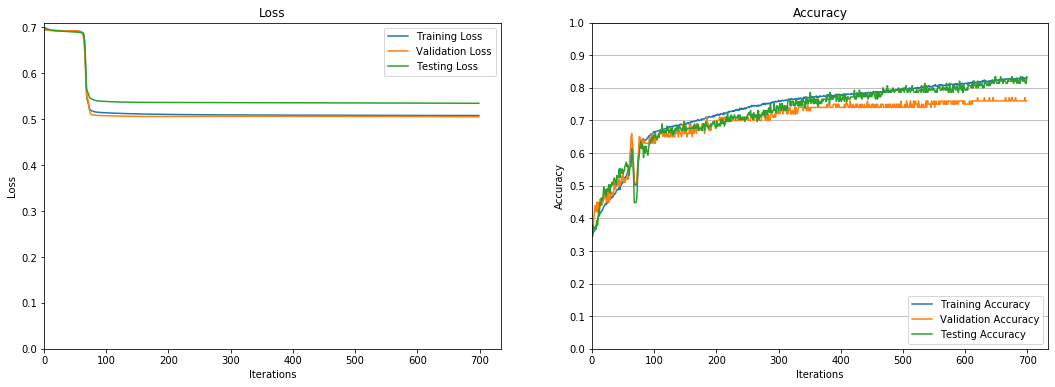

beta1: 0.99	beta2: 0.99	epsilon: 1e-09
Training loss: 0.5073		Training acc: 95.54%
Validation loss: 0.5249		Validation acc: 92.00%
Testing loss: 0.5397		Testing acc: 95.17%


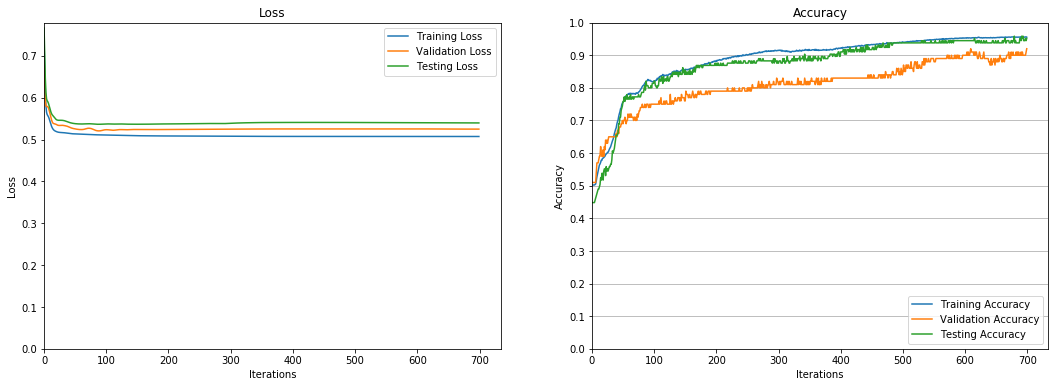

beta1: 0.99	beta2: 0.99	epsilon: 0.0001
Training loss: 0.5077		Training acc: 90.66%
Validation loss: 0.5059		Validation acc: 81.00%
Testing loss: 0.5362		Testing acc: 90.34%


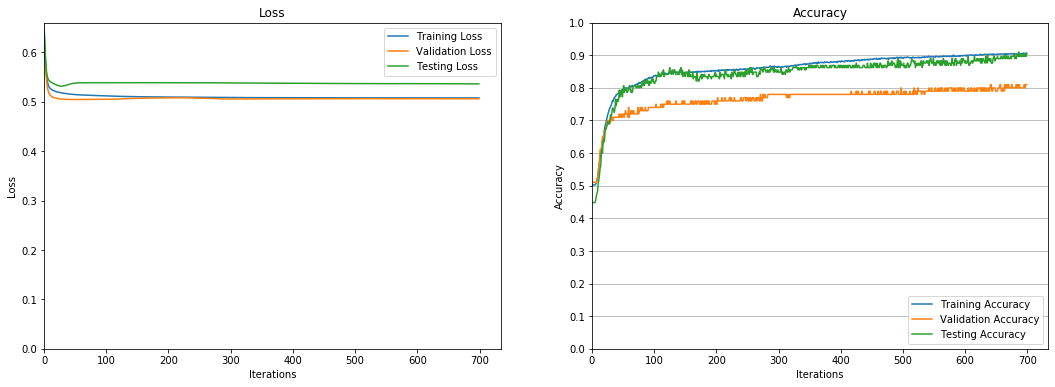

beta1: 0.99	beta2: 0.9999	epsilon: 1e-09
Training loss: 0.5078		Training acc: 85.80%
Validation loss: 0.5195		Validation acc: 78.00%
Testing loss: 0.5325		Testing acc: 85.52%


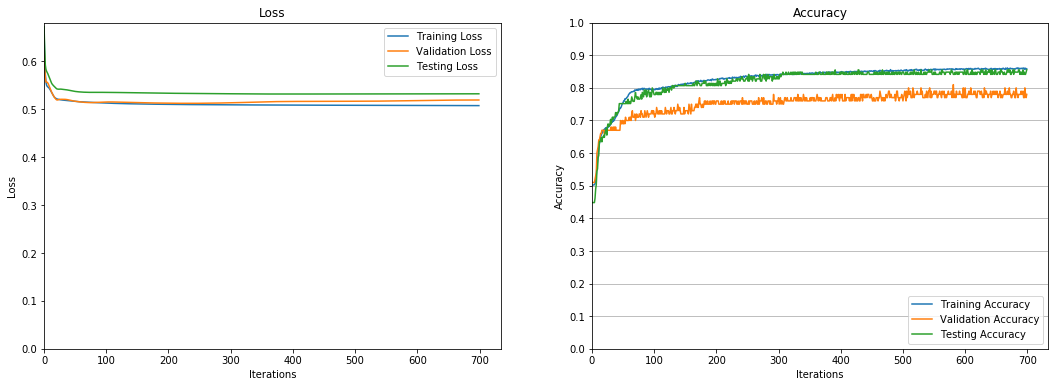

beta1: 0.99	beta2: 0.9999	epsilon: 0.0001
Training loss: 0.5085		Training acc: 85.06%
Validation loss: 0.5077		Validation acc: 77.00%
Testing loss: 0.5361		Testing acc: 84.83%


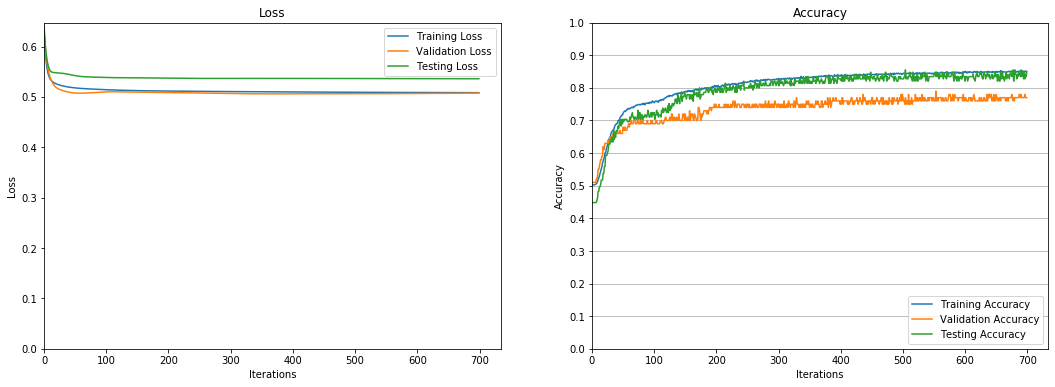

In [32]:
# 3.1.4 with Cross Entropy Loss
for beta1 in [0.95, 0.99]:
    for beta2 in [0.99, 0.9999]:
        for epsilon in [1e-9, 1e-4]:
            
            print(f"beta1: {beta1}\tbeta2: {beta2}\tepsilon: {epsilon}")
            
            w, b, *statistics = SGD(trainData, trainTarget, 
                                    alpha=0.001, 
                                    epochs=700, 
                                    reg=0,
                                    lossType='CE',
                                    batch_size=500,
                                    beta1=beta1, beta2=beta2, epsilon=epsilon,
                                    **VTDatasets)
            display_statistics(*statistics)

The binary cross entrop loss does much better than the MSE loss function. In all tests, the finall accuracy is larger than the MSE. The best final test accuracy for cross entropy was 95.17% compared to the best for MSE at 73.10%. It's clear that the difference is dramatic.

\newpage

### 6. Comparison against Batch GD {-}

One of the big differences between the SGD with Adam and batch gradient descent is how much quicker SGD is able to achieve the same results as BGD. BGD usually required 1000 epochs at minimum to stabilize the curves. SGD, on the other hand, was able to do so in fewer than 200 epochs. 

Concerning the accuracy plots, SGD with Adam creates creates an oscillating curve in most cases, before smoothing out. BGD, on the other hand, maintains a smooth curve throughout the training. This is most likely due to the nature of SGD working in random mini batches. As the algorithm finishes training on one mini batch, the accuracy is high. With the next random batch, however, the initial results are poor and the model needs to "retrain". This produces the oscillation in the curve. 
The loss graphs mirror this behaviour as well, with some of the loss graphs oscillating with the accuracy.